Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# 1. Подготовка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Признаки
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
NotRepaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
### Целевой признак
Price — цена (евро)

### имеются пропуски в столбцах VehicleType — тип автомобильного кузова, Gearbox — тип коробки передач, Model — модель автомобиля, FuelType — тип топлива, NotRepaired — была машина в ремонте или нет

### При просмотре данных в таблице заметны нулевые и излишне большие значения в столбцах мощность двигателя, цена и месяц регистрации. Рассмотрим их с помощью графиков

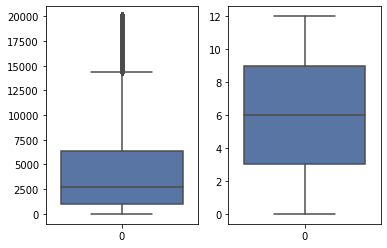

In [7]:
fig, axes = plt.subplots(1,2) 
sns.set(rc={'figure.figsize':(12,12)})
#plt.xlim(0, 2)
sns.boxplot(data=data['Price'], ax=axes[0])
sns.boxplot(data=data['RegistrationMonth'], ax=axes[1])
plt.show()

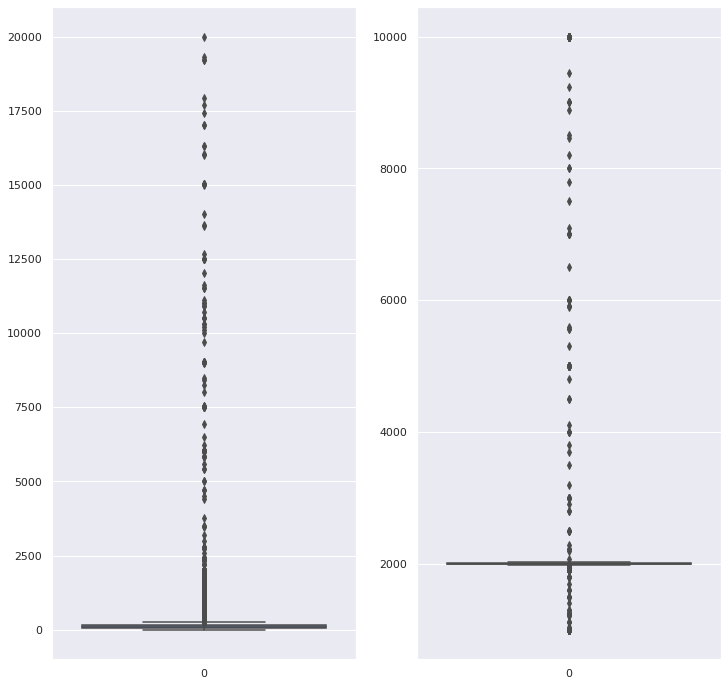

In [8]:
fig, axes = plt.subplots(1,2) 
sns.set(rc={'figure.figsize':(12,12)})
sns.boxplot(data=data['Power'], ax=axes[0])
sns.boxplot(data=data['RegistrationYear'], ax=axes[1])

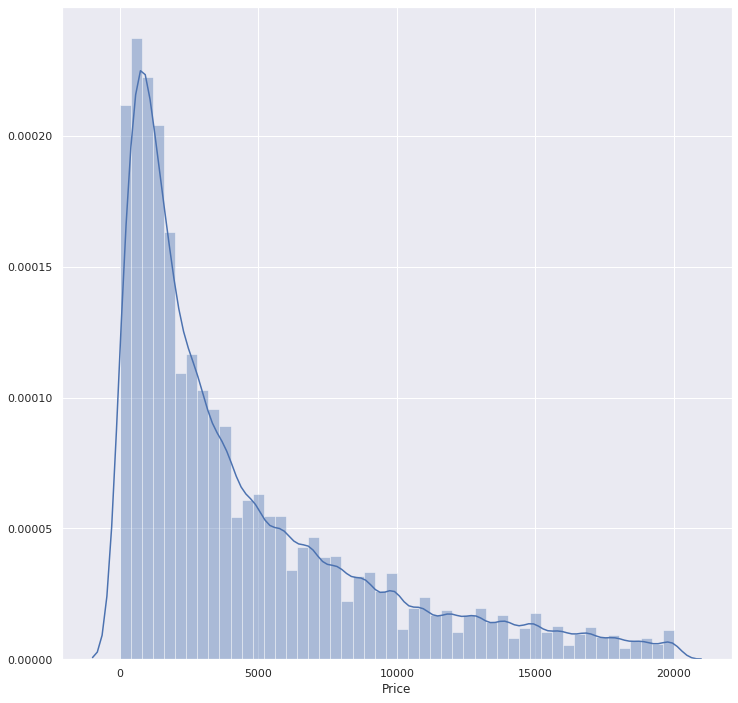

In [9]:
sns.distplot(data['Price'])

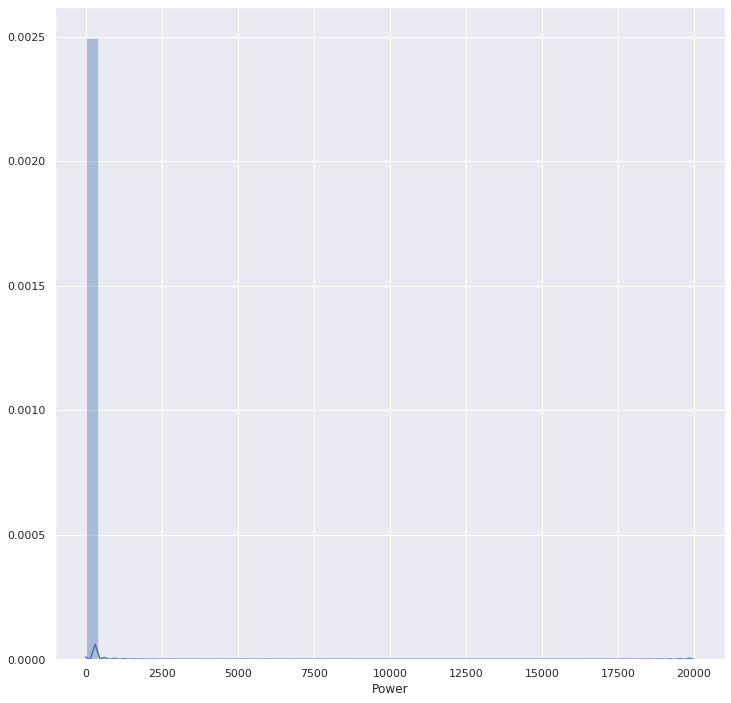

In [10]:
sns.distplot(data['Power'])

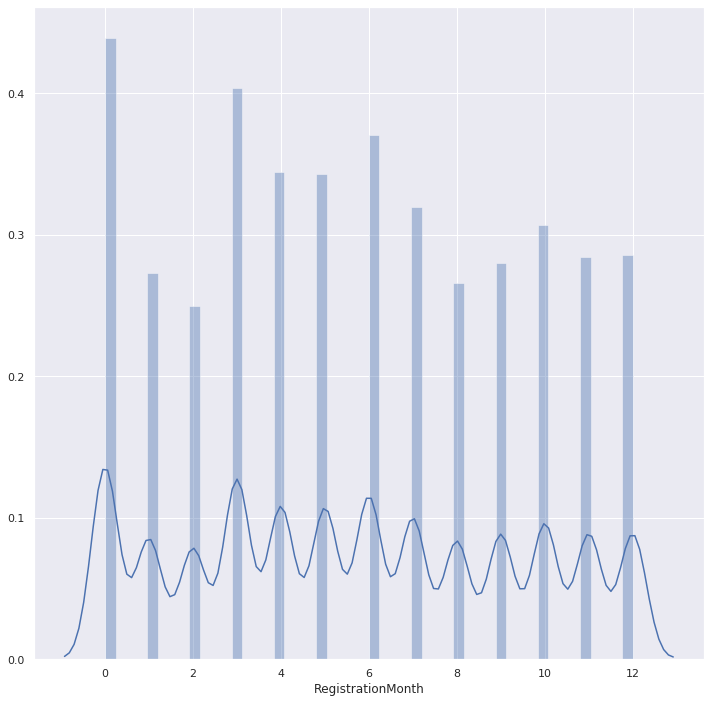

In [11]:
sns.distplot(data['RegistrationMonth'])

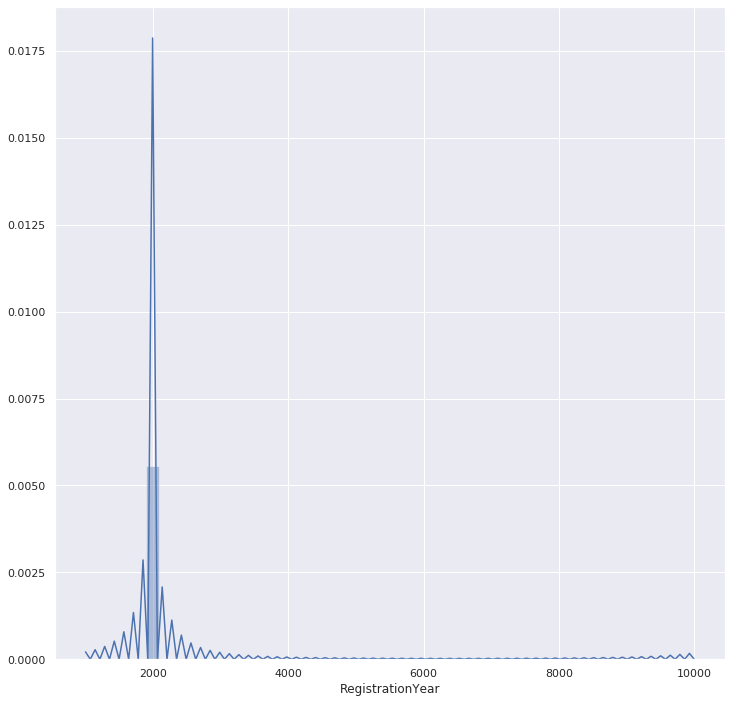

In [12]:
sns.distplot(data['RegistrationYear'])

### По значениям где присутствуют нулевые значения (цена, мощность и месяц регистрации) можно предположить, что при формировании анкеты эти показатели не были внесены пользователем и по умолчанию были приняты за нулевые значения, удалим строки с нулевыми значениями. Также наблюдаются значения в цене и мощности с необычными значеними - цены ниже 100 вряд ли возможны, а также значения мощности менее 50, также значения мощности более 300 в реальной жизни встречается кране редко и врядли такие автомобиле будут представлены на данной торговой площадке. По данным года регистрации наблюдаются выбросы как в большую так и в меньшую сторону от 1000 года до 9999 года. Это также отрицательно влияет на анализ, удалим выбросы.

In [13]:
data = data.loc[(data['Price']>100)&(
    data['RegistrationMonth']!=0)&(data['Power']>50)&(data['Power']<300)&
                                              (data['RegistrationYear']>1980)&
                                              (data['RegistrationYear']<2019)]

### в столбце NumberOfPictures находятся только нулевые значения, удалим эти данные

In [14]:
data = data.drop(['NumberOfPictures'], axis=1)

### Рассматривая признаки с отсутствующими значениями нельзя выявить зависимость изходя из которой можно заполнить пропуски. Просто удалить строки с пропусками не желательно из-за большого количества таких объектов. Примем пропуски как дополнительный класс None

In [15]:
# заменим NaN  на None 
data=data.fillna('None')

### Удалим столбцы содержащие информацию не относящиюся к объектам автомобиль, а несущим информацию о  статистике времени посещения.

In [16]:
# столбцы с значениями дата создания анкеты, дата скачивания анкеты, дата последней активности и 
# почтовый индекс пользователя не имеют значения для создания модели - удалим их 
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

###  Создадим список категорийных признаков для градиентного бустинга

In [17]:
# создадим список категорийных признаков для градиентного бустинга CatBoost и LightGBM
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired' ]

In [18]:
data.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
dtype: int64

### В таблице имеем категорийные признаки в строковом формате, преобразуем их числовые значения для возможности в последующем использования при обучении моделей.


In [19]:
for i in cat_features:
    labelencoder = LabelEncoder()
    data[i] = labelencoder.fit_transform(data[i])

### Разделим данные на признаки и целевой признак

In [20]:
target = data['Price']
features = data.drop('Price', axis=1)

### Разделим данные на обучающую, валидационую и тестовую выборки в соотношении 70/15/15

In [21]:
features_train, features_ft, target_train, target_ft = train_test_split(    
    features, target, test_size=0.30, random_state=12345)

In [22]:

features_test, features_valid, target_test, target_valid = train_test_split(    
    features_ft, target_ft, test_size=0.5, random_state=12345)

# 2. Обучение моделей

### Для проведения анализа обучим несколько моделей и подберем оптимальные параметры с поверкой по метрике RMSE. Приобучении зафиксируем затраченное время.

### обучим основываясь на библиотеке CatBoost

In [23]:
%%time
# обучим основываясь на библиотеке CatBoost
i = 0
result = pd.DataFrame(columns=['iteration','depth', 'learning_rate', 'rMSE'])
for iteration in range(20, 101, 10):
     for depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.5):
            model = CatBoostRegressor(loss_function='RMSE', iterations=iteration , depth=depth, learning_rate=learning_rate)
            model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
            pred_valid = model.predict(features_valid)
            result.loc[i] = [iteration, depth, learning_rate, mean_squared_error(target_valid, pred_valid)**0.5]
            i += 1
result.sort_values('rMSE').head(5)           

CPU times: user 22min 45s, sys: 2min 39s, total: 25min 24s
Wall time: 29min 35s


,iteration,depth,learning_rate,rMSE
89,100.0,9.0,0.6,1562.577729
79,90.0,9.0,0.6,1563.957121
69,80.0,9.0,0.6,1568.166314
59,70.0,9.0,0.6,1572.290445
49,60.0,9.0,0.6,1579.445070


In [24]:
%%time
# Обучим модель с оптимальными параметрами
model_cb = CatBoostRegressor(loss_function='RMSE', iterations=100 , depth=9, learning_rate=0.5)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=False)
pred_valid_cb = model_cb.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_cb)**0.5
rmse

CPU times: user 40 s, sys: 4.47 s, total: 44.5 s
Wall time: 47.5 s


1531.378783800643

### обучим основываясь на библиотеке LightGBM

In [25]:
%%time
# обучим основываясь на библиотеке lightGBM
i = 0
result = pd.DataFrame(columns=['max_depth','learning_rate', 'n_estimators', 'rMSE'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.2):
            model_lgb= lgb.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
            model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
            pred_valid_lgb = model_lgb.predict(features_valid)
            result.loc[i] = [max_depth, learning_rate, n_estimators, mean_squared_error(target_valid, pred_valid_lgb)**0.5]
            i += 1
result.sort_values('rMSE').head(5)   

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset

CPU times: user 13min 10s, sys: 1.86 s, total: 13min 11s
Wall time: 13min 21s


,max_depth,learning_rate,n_estimators,rMSE
246,9.0,0.3,100.0,1551.402130
241,7.0,0.3,100.0,1551.762488
221,9.0,0.3,90.0,1554.314975
216,7.0,0.3,90.0,1557.399411
196,9.0,0.3,80.0,1557.587687


In [26]:
%%time
# Обучим модель с оптимальными параметрами
model_lgb= lgb.LGBMRegressor(max_depth=7, learning_rate=0.3, n_estimators=100)
model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
pred_valid_lgb = model_lgb.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_lgb)**0.5
rmse

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 5.84 s, sys: 36 ms, total: 5.87 s
Wall time: 5.98 s


1546.0171154306838

### обучим основываясь на случайном лесе

In [27]:
%%time
# обучим основываясь на RandomForestRegressor
i = 0
result = pd.DataFrame(columns=['max_depth', 'n_estimators', 'rMSE'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        model_rfr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=12345)
        model_rfr.fit(features_train, target_train)
        pred_valid_rfr = model_rfr.predict(features_valid)
        result.loc[i] = [max_depth, n_estimators, mean_squared_error(target_valid, pred_valid_rfr)**0.5]
        i += 1
result.sort_values('rMSE').head(5) 

CPU times: user 11min 37s, sys: 0 ns, total: 11min 37s
Wall time: 11min 42s


,max_depth,n_estimators,rMSE
44,9.0,90.0,1930.170995
49,9.0,100.0,1930.301240
34,9.0,70.0,1930.462611
39,9.0,80.0,1930.635593
29,9.0,60.0,1931.232773


In [28]:
%%time
# Обучим модель с оптимальными параметрами
model_rfr = RandomForestRegressor(max_depth=9, n_estimators=50, random_state=12345)
model_rfr.fit(features_train, target_train)
pred_valid_rfr = model_rfr.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_rfr)**0.5
rmse

CPU times: user 22.1 s, sys: 0 ns, total: 22.1 s
Wall time: 22.2 s


1925.8956789475853

### обучим основываясь на линейной регрессии

In [29]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
pred_valid_LR = model_LR.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_LR)**0.5
rmse

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 104 ms


2947.8372074982003

# 3. Анализ моделей

### В предыдущем шаге были рассмотренны и обучены модели с помощью линейноу регрессии, случайном лесе и библиотеках градиентного бустинга CatBoost и LightGBM. При обучении был произеден подбор оптимальных параметров, а затем обучены модели с параметрами показавшими наилучшие результаты.
### При этом были получены различные результаты как по качеству, так и по времени обучения моделей. Наиболльшуюскорость показала линейная регрессии 104 мс, но при этом и наихудший результат по качеству RMCE= 2947.83, Случайный лес показал результат RMCE= 1925.89 при скорости 22.2 с. Градиентный бустинг был обучен также на основании случайного леса для сравнения с "простой"моделью RandomForestRegressor. При этом модель основаная на библиотеке CatBoost показала результат RMCE= 1531.37 с временем обучения 47.5 с, что превышает качество модели случайного леса, но немного проирывает ему в скорости. И наилучший результат показала модель основаная на библиотеке LightGBM RMCE= 1546.01 при скорости 5.98 с. 
### Данное сравнение результатов качества моделей и времеми выполнения операции позволяет рекомендовать для использования при построении модели градиентного бустинга, когда стоит ориентироватся на время выполнения операции библиотеку LightGBM, в случае когда необходима большая точность не смотря набольшее время выполнения следует использовать библиотеку CatBoost